### Setup

In [1]:
import sklearn
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings("ignore")

### MNIST dataset

MNIST dataset is a set of `70,000` `28x28` small images of digits handwritten by high school students and employees of the US Sensus Bureau. Each image is saved as a `28x28=784` long numpy array and labeled with the digit it represents.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(type(X))
print(type(y))
print(X.shape)
print(y.shape)
print(28*28)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(70000, 784)
(70000,)
784


In [4]:
y[10]

'3'

As these labels are saves as strigs, we need to convert them into integers since most ML algorithms expect numbers.

In [5]:
y = y.astype(np.uint8)

In [6]:
def plot_digit(data, label):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.title(label)

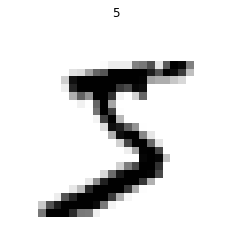

In [7]:
some_index = 0
some_digit = X[some_index]
plot_digit(some_digit, y[some_index])

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

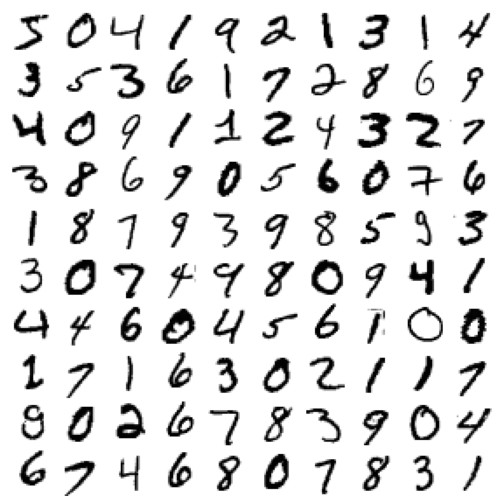

In [9]:
fig = plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [10]:
fig.savefig("images\more_digits_plot", bbox_inches='tight')

The MNIST dataset is actually already split into a training set(first `60,000` images) and a test set(last `10,000` images). The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be simitar.

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

Lets build a simple classifier to identify a given digit is `5` or not.

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Stochastic Gradient Descent(SGD) has the advantage of being capable of handling vary large datasets efficiently becouse it deals with training instances independently.

The `SGDClassifier` relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Lets see if the first 100 images are identifie as 5 or not.

In [14]:
sgd_clf.predict(X[0:100])

array([ True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

`Sklearn` provides a K-fold cross-validation tool to measure the performance of the fitted model.

In [15]:
from sklearn.model_selection import cross_val_score

sgd_CV_accuracy = cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")
print(sgd_CV_accuracy)

[0.95466667 0.96975    0.9635     0.96533333 0.94841667]


In [16]:
print(round(np.mean(sgd_CV_accuracy) * 100, 2))

96.03


To have more control over the cross-validation process we can implement the following.

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

CV_accuracy = []
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    CV_accuracy.append(n_correct / len(y_pred))
    
print(CV_accuracy)

[0.9598333333333333, 0.962, 0.9421666666666667, 0.9673333333333334, 0.9541666666666667]


In [18]:
print(round(np.mean(CV_accuracy) * 100, 2))

95.71


Lets try out a dumb classifier `BaseEstimator` that just classifies every image to the `not-5` class and check the CV-accuracy.

In [19]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
base_CV_accuracy = cross_val_score(never_5_clf, X_train, y_train_5, cv=5, scoring="accuracy")
print(base_CV_accuracy)

[0.91266667 0.90866667 0.9095     0.90883333 0.90858333]


In [21]:
print(round(np.mean(base_CV_accuracy) * 100, 2))

90.96


This gives a `90%` CV-accuracy (ratio of correct predicitons). But since we are trying to classify only one digit out of `10`, if you always guess that an image is not a `5`, you will be right about `90%` of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)
cm = confusion_matrix(y_train_5, y_train_pred)

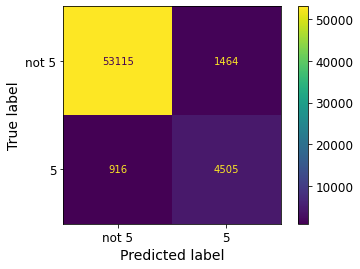

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = ['not 5', '5'])
disp.plot()
plt.show()

### Precision and Recall

 - Precision - accuracy of the positive predictions
 - Recall - ratio of positive instances that are correctly detected
 
$\text{Precision} = \dfrac{TP}{TP+FP} \qquad$   and   $\qquad \text{Recall} = \dfrac{TP}{TP+FN}$
 
Making one single positive prediction gives `precision = 1/1 = 100%`. Thus Precision is calculated with Recall.

In [24]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(cm[1, 1] / (cm[0, 1] + cm[1, 1]))

0.7547327860613168
0.7547327860613168


In [25]:
print(recall_score(y_train_5, y_train_pred))
print(cm[1, 1] / (cm[1, 0] + cm[1, 1]))

0.8310274857037447
0.8310274857037447


Precision tells that the classifier is correct only `83.7%`
of the time. Moreover it detects `65.1%` of the `5`'s.

F1 score is another Measures we can look at.

$\text{F}_{1} = \dfrac{2}{\dfrac{1}{\text{Precision}} + \dfrac{1}{\text{Recall}}} 
= 2 \times \dfrac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

In [26]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))
print(cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2))

0.791044776119403
0.7910447761194029


### Precision/Recall Trade-off

Classifiers use a threshold value to make decisions. For example:
 - The `SGDClassifier` computes a score based on a `decision funciton` for each instance and if it is greater than a threshold value (red line), it assigns the instance to the positive class; oterhwise to the negative class.

In [27]:
y_scores = sgd_clf.decision_function([X[10]])
y_scores

array([-5711.47789687])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [29]:
y_some_digit_pred

array([False])

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5,
                             method="decision_function")
print(y_scores)

[  4411.53413566 -14087.12193543 -21565.51993633 ...   9394.4695853
  -2918.25117218  -9160.6081938 ]


These are the scores calculated by the classifier for each instance. Using a threshold value it makes predictions. Unfortunatly `Sciket-Learn` does not let you set the threshold directly.

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

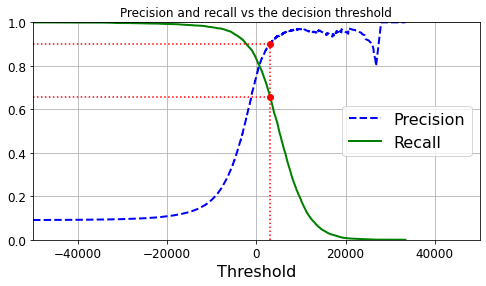

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])            


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


fig = plt.figure(figsize=(8, 4))                                                                
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro") 
plt.title("Precision and recall vs the decision threshold")
plt.show()

This plot shows the trade-off between Precision and Recall. By setting a certain threshold value we can see how the Precision and Recall scores makes a trade-off.

In [34]:
fig.savefig("images\precision_recall_vs_threshold_plot", bbox_inches='tight')

In [35]:
(y_train_pred == (y_scores > 0)).all()

True

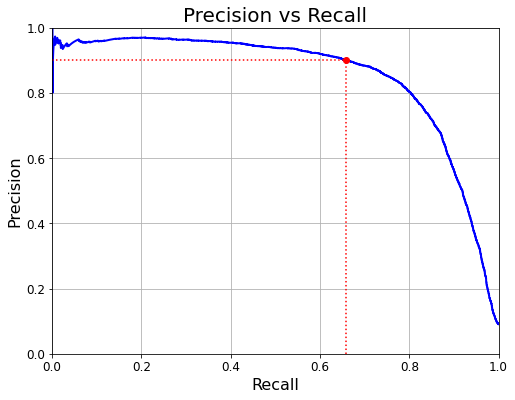

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

fig = plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.title("Precision vs Recall", fontsize=20)
plt.show()

In [37]:
fig.savefig("images\precision_vs_recall_plot", bbox_inches='tight')

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [39]:
threshold_90_precision

3045.925822705365

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9002016129032258

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.6589190186312488

## The ROC Curve

The **Receiver Operating Characteristic (ROC)** curve is another common tool used with binary classifiers. It plots the false positive rate (FPR) vs true positive rate (TPR or Recall)
 - FPR = 1 - TNR = 1 - specificity
 - TPR = sensitivity

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

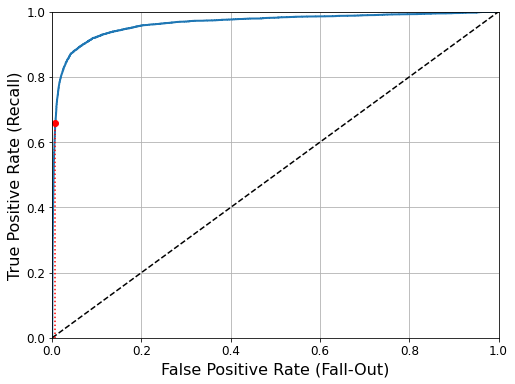

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

fig = plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                   
plt.show()

In [45]:
fig.savefig("images\\roc_curve_plot", bbox_inches='tight')

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9648211175804801

**Note**: we set `n_estimators=100` to be future-proof since this will be the default value in Scikit-Learn 0.22.

Let’s train a `RandomForestClassifier` and compare its ROC curve and ROC AUC
score to the `SGDClassifier`. First, you need to get scores for each instance in the training set. But due to the way it works, the RandomForestClassifier class does not have a `decision_function()` method. Instead it has a `predict_proba()` method. Scikit-Learn classifiers generally have one or the other. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5).

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, 
                                    X_train, 
                                    y_train_5, 
                                    cv=5,
                                    method="predict_proba")

In [48]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

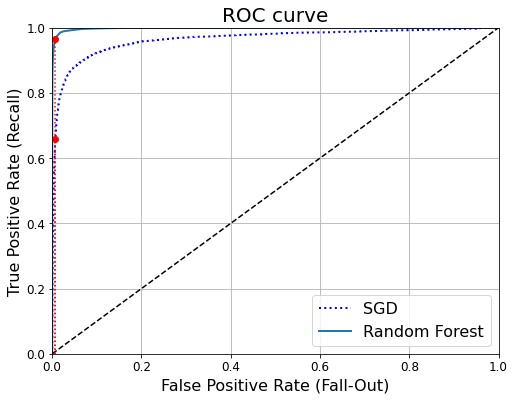

In [49]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

fig = plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.title("ROC curve", fontsize=20)
plt.show()

In [50]:
fig.savefig("images\\roc_curve_comparison_plot", bbox_inches='tight')

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.998402186461512

In [52]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5)
precision_score(y_train_5, y_train_pred_forest)

0.9910004185851821

In [53]:
recall_score(y_train_5, y_train_pred_forest)

0.8734550820881756

### Multiclass Classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers. 
 - one-versus-all (OvA) strategy
 
Train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.
 - one-versus-one (OvO) strategy
 
Train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. If there are `N` classes, you need to train `N×(N–1)/2 = 45` classifiers. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred. 

`Scikit-Learn` detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).


In [54]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([X[10]])

array([3], dtype=uint8)

In [55]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [56]:
np.argmax(some_digit_scores)

5

In [57]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [58]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

In [59]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
len(ovr_clf.estimators_)

10

Training an `SGDClassifier` (or `RandomForestClassifier`) is just as easy as follows. `Scikit-Learn` did not have to run OvR or OvO because `SGDClassifier` can directily classify instances into multiple classes.

In [61]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [62]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**Warning**: the following two cells may take close to 30 minutes to run, or more depending on your hardware.

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=5, scoring="accuracy")

array([0.89733333, 0.88725   , 0.89583333, 0.89233333, 0.90516667])

# Error Analysis

In [104]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)
conf_mx = confusion_matrix(y_train, y_train_pred)

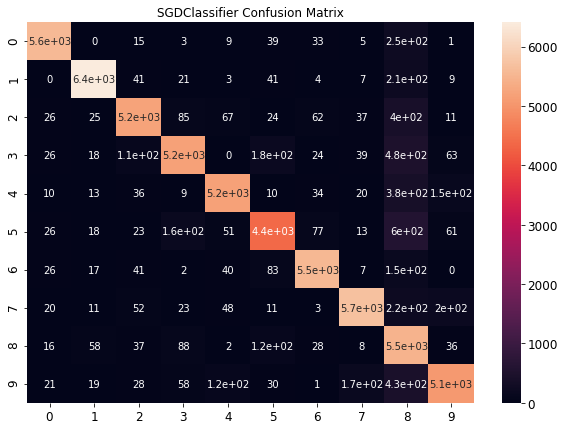

In [105]:
import seaborn as sn

fig = plt.figure(figsize = (10,7))
sn.heatmap(conf_mx, annot=True)
plt.title("SGDClassifier Confusion Matrix")
plt.show()

In [71]:
fig.savefig("images\\SGDClassifier Confusion Matrix", bbox_inches='tight')

To compare error rates of each class, lets devide each row that represents True labels by the sum of the corresponding row.

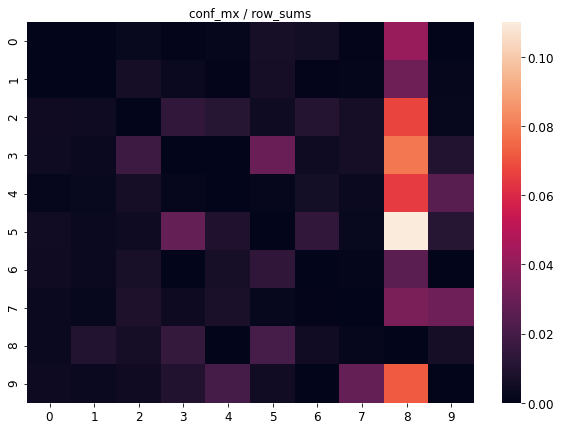

In [119]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize = (10,7))
sn.heatmap(norm_conf_mx, annot=False)
plt.title("conf_mx / row_sums")
plt.show()


# plt.matshow(norm_conf_mx, cmap=plt.cm.bone)
# plt.title("conf_mx / row_sums")
# plt.show()

In [120]:
fig.savefig("images\\SGDClassifier conf_mx over row_sums", bbox_inches='tight')

Note that the largest misclassified class is the 8th class. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily
symmetrical. You can also see that 3s and 5s often get confused (in both directions).

Analyzing the confusion matrix here's how you can improve your classifier.  
 - Reduce the false 8s. Try to gather more training data for digits that look like 8s (but are not) so the classifier can learn to distinguish them from real 8s. 
 - Engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). 
 - Preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

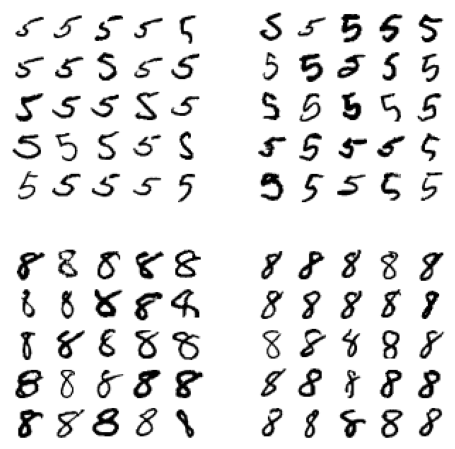

In [74]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
# save_fig("error_analysis_digits_plot")
plt.show()

### Multilabel Classification
In some cases you may want your classifier to output multiple classes for each instance. For example, consider a face-recognition classifier recognizes several people on the same picture. Such a classification system that outputs multiple binary tags is called a multilabel classification system.

This code creates a `y_multilabel` array containing two target labels for each digit image: 
 - The first indicates whether or not the digit is large (7, 8, or 9) 
 - The second indicates whether or not it is odd. 
 
The next lines create a `KNeighborsClassifier` instance (which supports multilabel classification, but not all classifiers do) and we train it using the multiple targets array.

In [75]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [76]:
knn_clf.predict([some_digit])

array([[False,  True]])

To measure the performance of the multilabel classifier, we can compute  the F1 score for each label then take the average score.

When each class in the training dataset contains different amount of data, simply set `average="weighted"`.

In [77]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=5)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.977511478985599

### Multioutput-multiclass Classification

This is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

In [78]:
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test  = np.random.randint(0, 100, (len(X_test), 784))

X_train_mod = X_train + noise_train
X_test_mod  = X_test + noise_test
y_train_mod = X_train
y_test_mod  = X_test

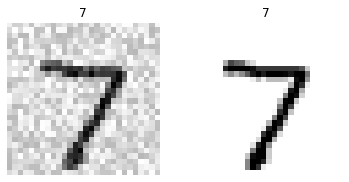

In [79]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index], y_test[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index], y_test[some_index])
# save_fig("noisy_digit_example_plot")
plt.show()

On the left is the noisy input image, and on the right is the clean target image. Now let’s train the classifier and make it clean this image.

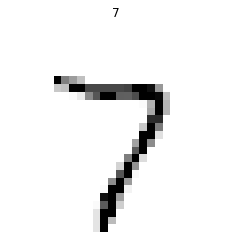

In [80]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit, y_test[some_index])
# save_fig("cleaned_digit_example_plot")

### Extra classifiers

### Dummy (ie. random) classifier

In [81]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=5, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

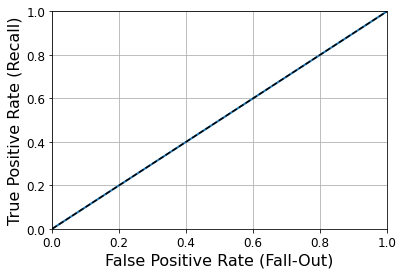

In [82]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

### KNN classifier

In [83]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [84]:
y_knn_pred = knn_clf.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

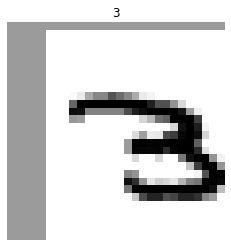

In [86]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

some_index = 250
some_digit = X[some_index]
plot_digit(shift_digit(some_digit, 5, 1, new=100), y[some_index])

In [87]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [88]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [89]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [90]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

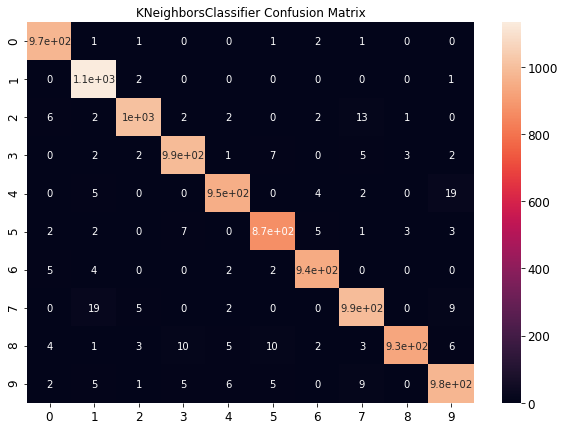

In [122]:
conf_mx = confusion_matrix(y_test, y_knn_expanded_pred)

plt.figure(figsize = (10,7))
sn.heatmap(conf_mx, annot=True)
plt.title("KNeighborsClassifier Confusion Matrix")
plt.show()

In [123]:
fig.savefig("images\\KNeighborsClassifier Confusion Matrix", bbox_inches='tight')

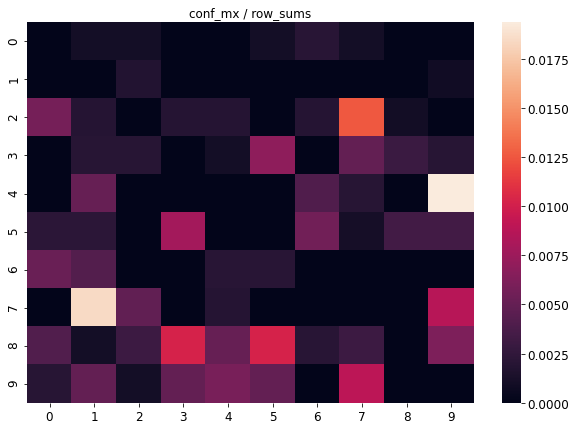

In [124]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.figure(figsize = (10,7))
sn.heatmap(norm_conf_mx, annot=False)
plt.title("conf_mx / row_sums")
plt.show()

In [125]:
fig.savefig("images\\SGDClassifier conf_mx over row_sums", bbox_inches='tight')

In [98]:
some_index = 2589
ambiguous_digit = X_test[some_index]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

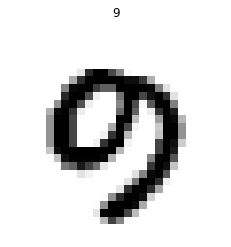

In [99]:
plot_digit(ambiguous_digit, y_test[some_index])